# 다중분류회귀 모델링
RandomForest, XGBoost, LGBM 모델을 사용했고, Randomized Search CV를 사용하여 하이퍼 파라미터를 튜닝했다.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
plt.rc('font', family='NanumBarunGothic') 
from category_encoders import OneHotEncoder,OrdinalEncoder, TargetEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from datetime import datetime
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import shap
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from catboost import Pool,CatBoostClassifier

In [3]:
DATA_PATH = ''
df_final = pd.read_csv(f'{DATA_PATH}df_final.csv')
df_final.head()         

,날짜,시간,업종,시도,구,월,time,기온,체감온도,일강수량,...,30대,40대,50대,60대,70대,80대,90대이상,미세,초미세,주문정도
0,2019-05-19,14,치킨,서울특별시,중구,5,2019.05.19.14,21.0,24.1,12.8,...,21749,18632,20811,16464,9514,3846,541,11.0,8.0,1
1,2019-05-27,23,치킨,서울특별시,중구,5,2019.05.27.23,15.3,16.5,7.1,...,21749,18632,20811,16464,9514,3846,541,11.0,5.0,1
2,2019-05-30,12,치킨,서울특별시,중구,5,2019.05.30.12,23.9,22.8,0.0,...,21749,18632,20811,16464,9514,3846,541,38.0,20.0,1
3,2019-06-01,22,치킨,서울특별시,중구,6,2019.06.01.22,17.5,18.9,0.0,...,21749,18632,20811,16464,9514,3846,541,19.0,14.0,1
4,2019-06-05,19,치킨,서울특별시,중구,6,2019.06.05.19,24.9,25.6,0.0,...,21749,18632,20811,16464,9514,3846,541,50.0,36.0,1


In [4]:
df_final.drop(columns = ['날짜', 'time', '시도'],inplace = True)
df_final.head()

,시간,업종,구,월,기온,체감온도,일강수량,상대습도,적설,풍속,...,30대,40대,50대,60대,70대,80대,90대이상,미세,초미세,주문정도
0,14,치킨,중구,5,21.0,24.1,12.8,91.0,0.0,1.5,...,21749,18632,20811,16464,9514,3846,541,11.0,8.0,1
1,23,치킨,중구,5,15.3,16.5,7.1,62.0,0.0,3.5,...,21749,18632,20811,16464,9514,3846,541,11.0,5.0,1
2,12,치킨,중구,5,23.9,22.8,0.0,35.0,0.0,3.8,...,21749,18632,20811,16464,9514,3846,541,38.0,20.0,1
3,22,치킨,중구,6,17.5,18.9,0.0,65.0,0.0,1.1,...,21749,18632,20811,16464,9514,3846,541,19.0,14.0,1
4,19,치킨,중구,6,24.9,25.6,0.0,57.0,0.0,1.9,...,21749,18632,20811,16464,9514,3846,541,50.0,36.0,1


In [5]:
#학습, 검증, 테스트 데이터 분리
X_train, X_test = train_test_split(df_final, test_size = 0.2, random_state = 42)
X_train, X_val = train_test_split(X_train, test_size = 0.2, random_state = 42)
y_train, y_val, y_test = X_train.pop('주문정도'), X_val.pop('주문정도'), X_test.pop('주문정도')
display(X_train.head())
display(X_val.head())
display(y_train.head())

,시간,업종,구,월,기온,체감온도,일강수량,상대습도,적설,풍속,...,20대,30대,40대,50대,60대,70대,80대,90대이상,미세,초미세
220381,14,카페/디저트,구로구,4,17.5,15.8,0.0,0.0,23.0,2.4,...,55435,67782,66894,71362,61764,32081,11138,1316,31.0,22.850503
191931,21,돈까스/일식,관악구,11,9.6,9.6,0.0,0.0,65.0,1.2,...,113842,91281,69274,70623,60404,36260,11928,1399,39.0,26.000000
218370,23,카페/디저트,구로구,4,11.8,12.0,0.0,0.0,42.0,1.3,...,55435,67782,66894,71362,61764,32081,11138,1316,53.0,22.000000
195845,4,패스트푸드,관악구,12,1.6,-1.5,0.0,0.0,59.0,2.9,...,113842,91281,69274,70623,60404,36260,11928,1399,30.0,19.000000
361189,22,분식,도봉구,8,25.4,28.4,97.0,88.0,0.0,0.8,...,43631,41171,48240,56364,47731,27177,11147,1542,14.0,8.000000


,시간,업종,구,월,기온,체감온도,일강수량,상대습도,적설,풍속,...,20대,30대,40대,50대,60대,70대,80대,90대이상,미세,초미세
309006,23,분식,금천구,10,14.0,13.8,0.0,0.0,75.0,2.0,...,36573,39196,36478,45649,36456,18108,6170,746,26.0,17.0
76682,0,분식,구로구,11,3.0,-0.1,7.5,0.0,51.0,3.2,...,55916,70334,68362,72672,59195,30190,10270,1202,12.0,11.0
623548,18,배달전문업체,동작구,3,6.5,3.7,0.0,0.0,57.0,3.9,...,72505,64378,57849,60030,52065,29500,12016,1531,23.0,12.0
651823,17,아시안/양식,관악구,2,8.6,6.4,0.0,0.0,59.0,3.7,...,113253,90908,67481,70006,62736,36618,13030,1497,40.0,25.0
493466,22,분식,강북구,3,5.3,2.5,0.0,0.0,72.0,3.5,...,42810,38989,45696,51306,43935,29004,10496,1245,90.0,53.0


220381    3
191931    1
218370    1
195845    1
361189    1
Name: 주문정도, dtype: int64

In [6]:
X_train.shape, X_val.shape, X_test.shape

((461719, 26), (115430, 26), (144288, 26))

In [7]:
#랜덤포레스트
#타겟인코더 사용
pipe_rf = make_pipeline(TargetEncoder(min_samples_leaf = 2, smoothing = 1000),
                       RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1))  

pipe_rf.fit(X_train, y_train)

#과적합 발생
print(pipe_rf.score(X_train, y_train))
print(pipe_rf.score(X_val, y_val))

y_prob = pipe_rf.predict_proba(X_train) 
print('학습 AUC',roc_auc_score(y_train, y_prob, multi_class="ovr", average="weighted"))

y_prob = pipe_rf.predict_proba(X_val)
print(roc_auc_score(y_val, y_prob, multi_class="ovr", average="weighted")) #변수를 추가하니까 0.826에서 0.833으로 증가

0.9999870050831783
0.6876115394611453
학습 AUC 0.9999999994093625
0.8359469847372205


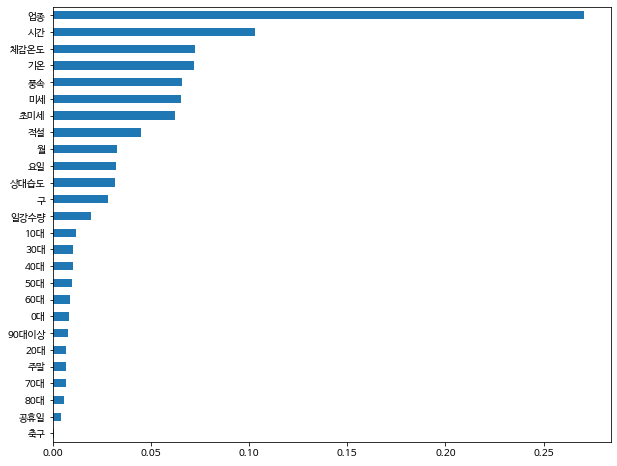

In [25]:
#변수 중요도 그래프
fig = plt.figure(figsize = (10,8))
pd.Series(pipe_rf.named_steps['randomforestclassifier'].feature_importances_, index = X_val.columns).sort_values().plot.barh()

In [26]:
#Xgboost
pipe_xgb = make_pipeline(TargetEncoder(min_samples_leaf = 2, smoothing = 1000),
                       XGBClassifier(n_estimators = 100, random_state = 42, n_jobs = -1))  

pipe_xgb.fit(X_train, y_train)

#과적합 없음
print(pipe_xgb.score(X_train, y_train))
print(pipe_xgb.score(X_val, y_val)) #검증 정확도도 Random Forest에 비해 증가

y_prob = pipe_xgb.predict_proba(X_train) 
print('학습 AUC',roc_auc_score(y_train, y_prob, multi_class="ovr", average="weighted"))

y_prob = pipe_xgb.predict_proba(X_val) 
print('검증 AUC', roc_auc_score(y_val, y_prob, multi_class="ovr", average="weighted")) #AUC가 0.8279에서 훨씬 증가

[14:42:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7238666808166873
0.7180282422247249
학습 AUC 0.8715909640648501
검증 AUC 0.8602456821864018


In [8]:
#LGBM
pipe_lgbm = make_pipeline(TargetEncoder(min_samples_leaf = 2, smoothing = 1000),
                       LGBMClassifier(n_estimators = 100, random_state = 42, n_jobs = -1))  

pipe_lgbm.fit(X_train, y_train)

# 과적합 없음
print(pipe_lgbm.score(X_train, y_train))
print(pipe_lgbm.score(X_val, y_val)) #정확도도 증가

y_prob = pipe_lgbm.predict_proba(X_train) 
print('학습 AUC',roc_auc_score(y_train, y_prob, multi_class="ovr", average="weighted"))

y_prob = pipe_lgbm.predict_proba(X_val) 
print(roc_auc_score(y_val, y_prob, multi_class="ovr", average="weighted")) #AUC가 0.8279에서 훨씬 증가

0.7067458779040932
0.7056830979814607
학습 AUC 0.8495883340247767
0.8451279335915096


### 성능이 좋은 XGBoost와 LGBM으로 파라미터 튜닝을 해보자.

In [5]:
#파이프를 넣으면 정확도와 AUC를 계산하는 함수
def accuracy_and_auc(pipe):
    print('학습 정확도', pipe.score(X_train, y_train))
    print('검증 정확도', pipe.score(X_val, y_val))
    y_prob = pipe.predict_proba(X_train)
    train_roc = roc_auc_score(y_train, y_prob, multi_class="ovr", average="weighted")
    print('학습 AUC',train_roc)

    y_prob = pipe.predict_proba(X_val)
    val_roc = roc_auc_score(y_val, y_prob, multi_class="ovr", average="weighted")
    print('검증 AUC', val_roc)
    print('학습과 검증 AUC 차이', train_roc - val_roc )
    
    
def accuracy_and_auc2(xgb):
    print('학습 정확도', xgb.score(X_train_encoded, y_train))
    print('검증 정확도', xgb.score(X_val_encoded, y_val))
    y_prob = xgb.predict_proba(X_train_encoded)
    train_roc = roc_auc_score(y_train, y_prob, multi_class="ovr", average="weighted")
    print('학습 AUC',roc_auc_score(y_train, y_prob, multi_class="ovr", average="weighted"))

    y_prob = xgb.predict_proba(X_val_encoded)
    val_roc = roc_auc_score(y_val, y_prob, multi_class="ovr", average="weighted")

    print('검증 AUC', roc_auc_score(y_val, y_prob, multi_class="ovr", average="weighted"))
    print('학습과 검증 AUC 차이', train_roc - val_roc )

    

In [29]:
%%time
encoder = TargetEncoder(min_samples_leaf = 2, smoothing = 1000)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_val_encoded = encoder.transform(X_val)
xgb =  XGBClassifier(n_estimators = 1000, random_state = 42, n_jobs = -1, tree_method = 'gpu_hist', predictor = 'gpu_predictor')

dists = {
    'xgbclassifier__max_depth': np.arange(5,9,1),
    'xgbclassifier__learning_rate' : np.arange(0.025, 0.05, 0.005),
    'xgbclassifier__max_features': uniform(0,1)
}

clf_xgb = RandomizedSearchCV(
    xgb,
    param_distributions = dists,
    n_iter = 100,
    cv = 5,
    scoring = 'roc_auc_ovr_weighted',
    verbose = 1,
    n_jobs = -1
)
eval_set = [(X_train_encoded, y_train),
           (X_val_encoded, y_val)]
clf_xgb.fit(X_train_encoded, y_train, eval_set = eval_set, eval_metric = 'auc', early_stopping_rounds = 10)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed: 66.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 79.6min finished


[16:07:29] WARNING: ../src/learner.cc:576: 
Parameters: { "xgbclassifier__learning_rate", "xgbclassifier__max_depth", "xgbclassifier__max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.75617	validation_1-auc:0.75529
[1]	validation_0-auc:0.76795	validation_1-auc:0.76664
[2]	validation_0-auc:0.77308	validation_1-auc:0.77180
[3]	validation_0-auc:0.77771	validation_1-auc:0.77633
[4]	validation_0-auc:0.78119	validation_1-auc:0.77976
[5]	validation_0-auc:0.78470	validation_1-auc:0.78321
[6]	validation_0-auc:0.78886	validation_1-auc:0.78716
[7]	validation_0-auc:0.79199	validation_1-auc:0.79009
[8]	validation_0-auc:0.79514	validation_1-auc:0.79306
[9]	validation_0-auc:0.79877	validation_1-auc:0.79664
[10]	validation_0-auc:

[141]	validation_0-auc:0.87965	validation_1-auc:0.86439
[142]	validation_0-auc:0.87986	validation_1-auc:0.86453
[143]	validation_0-auc:0.88000	validation_1-auc:0.86458
[144]	validation_0-auc:0.88016	validation_1-auc:0.86463
[145]	validation_0-auc:0.88034	validation_1-auc:0.86470
[146]	validation_0-auc:0.88054	validation_1-auc:0.86479
[147]	validation_0-auc:0.88067	validation_1-auc:0.86485
[148]	validation_0-auc:0.88088	validation_1-auc:0.86498
[149]	validation_0-auc:0.88099	validation_1-auc:0.86506
[150]	validation_0-auc:0.88115	validation_1-auc:0.86505
[151]	validation_0-auc:0.88121	validation_1-auc:0.86505
[152]	validation_0-auc:0.88149	validation_1-auc:0.86530
[153]	validation_0-auc:0.88168	validation_1-auc:0.86538
[154]	validation_0-auc:0.88186	validation_1-auc:0.86550
[155]	validation_0-auc:0.88199	validation_1-auc:0.86552
[156]	validation_0-auc:0.88223	validation_1-auc:0.86566
[157]	validation_0-auc:0.88243	validation_1-auc:0.86575
[158]	validation_0-auc:0.88282	validation_1-auc:

[288]	validation_0-auc:0.89745	validation_1-auc:0.87093
[289]	validation_0-auc:0.89751	validation_1-auc:0.87093
[290]	validation_0-auc:0.89760	validation_1-auc:0.87092
[291]	validation_0-auc:0.89768	validation_1-auc:0.87097
[292]	validation_0-auc:0.89776	validation_1-auc:0.87098
[293]	validation_0-auc:0.89782	validation_1-auc:0.87097
[294]	validation_0-auc:0.89791	validation_1-auc:0.87096
[295]	validation_0-auc:0.89794	validation_1-auc:0.87096
[296]	validation_0-auc:0.89807	validation_1-auc:0.87098
[297]	validation_0-auc:0.89817	validation_1-auc:0.87099
[298]	validation_0-auc:0.89824	validation_1-auc:0.87100
[299]	validation_0-auc:0.89833	validation_1-auc:0.87101
[300]	validation_0-auc:0.89841	validation_1-auc:0.87101
[301]	validation_0-auc:0.89848	validation_1-auc:0.87100
[302]	validation_0-auc:0.89856	validation_1-auc:0.87103
[303]	validation_0-auc:0.89870	validation_1-auc:0.87116
[304]	validation_0-auc:0.89878	validation_1-auc:0.87117
[305]	validation_0-auc:0.89890	validation_1-auc:

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           tree_method='gpu_hist',
                                           validate_parameters=None,
                                           ve

In [30]:
print("Best Parameter: {}".format(clf_xgb.best_params_))

Best Parameter: {'xgbclassifier__learning_rate': 0.030000000000000002, 'xgbclassifier__max_depth': 5, 'xgbclassifier__max_features': 0.7697637584605892}


In [ ]:
xgb_best = clf_xgb.best_estimator_
xgb_best.fit(X_train_encoded, y_train, eval_set = eval_set, eval_metric = 'auc', early_stopping_rounds = 10)

In [35]:
#과적합이 좀 있다.
accuracy_and_auc2(xgb_best)

학습 정확도 0.7530077817893567
검증 정확도 0.7268994195616391
학습 AUC 0.9018008118985247
검증 AUC 0.8716961904034436


In [50]:
#과적합을 줄이기 위해 필요없는 변수를 없애고 다시 돌려보자.
#permutation importance는 다중분류에서 적용되지 않는다.
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_val_encoded.iloc[:500])

shap.initjs()

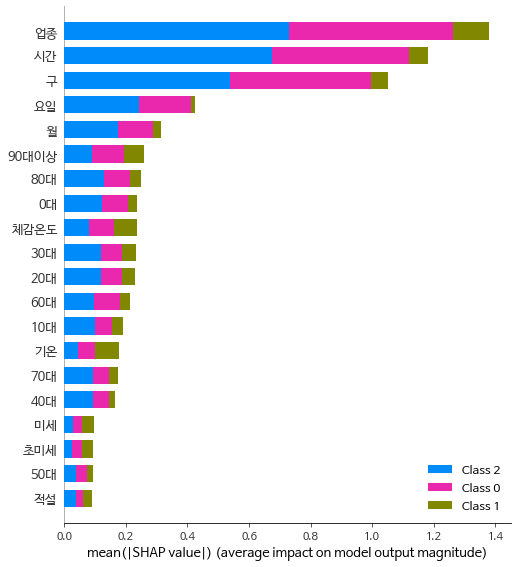

In [51]:
#다중 분류라 해당 변수가 어떤 클래스에 영향을 미쳤는지 표시됨.
shap.summary_plot(shap_values, X_val_encoded.iloc[:500], plot_type = 'bar')

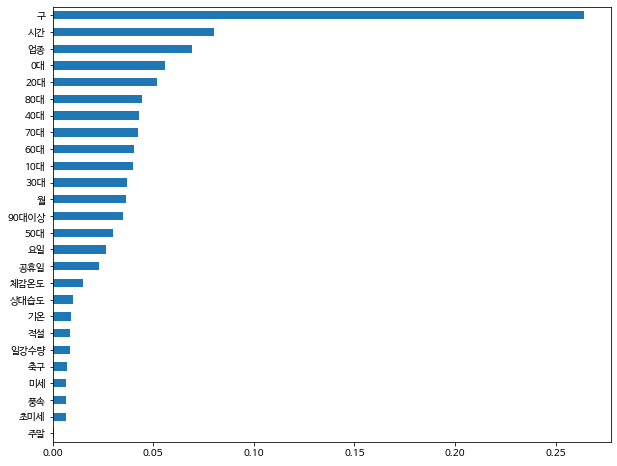

In [52]:
fig = plt.figure(figsize = (10,8))
pd.Series(xgb_best.feature_importances_, index = X_val.columns).sort_values().plot.barh()

In [75]:
#두 가지 중요도 그래프에서 모두 순위가 낮은 변수는 제거해보자.
# 주말, 초미세, 풍속, 미세,축구
print(df_final.shape)
df_final2 = df_final.drop(columns = ['주말', '초미세', '풍속', '미세', '축구'])
print(df_final2.shape)

X_train, X_test = train_test_split(df_final2, test_size = 0.2, random_state = 42)
X_train, X_val = train_test_split(X_train, test_size = 0.2, random_state = 42)
y_train, y_val, y_test = X_train.pop('주문정도'), X_val.pop('주문정도'), X_test.pop('주문정도')

encoder = TargetEncoder(min_samples_leaf = 2, smoothing = 1000)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_val_encoded = encoder.transform(X_val)

(721437, 27)
(721437, 22)


In [147]:
#필요없는 변수를 좀 줄이고, n_estimators가 학습이 좀 덜 되게 함으로써 과적합을 줄인다.
xgb2 =  XGBClassifier(n_estimators = 120, random_state = 42, n_jobs = -1, tree_method = 'gpu_hist', predictor = 'gpu_predictor',
                     max_depth = 6, learning_rate = 0.25)
eval_set = [(X_train_encoded, y_train),
           (X_val_encoded, y_val)]
xgb2.fit(X_train_encoded, y_train, eval_set = eval_set, eval_metric = 'auc', early_stopping_rounds = 5)

[0]	validation_0-auc:0.75607	validation_1-auc:0.75518
[1]	validation_0-auc:0.76444	validation_1-auc:0.76325
[2]	validation_0-auc:0.77201	validation_1-auc:0.77060
[3]	validation_0-auc:0.77393	validation_1-auc:0.77258
[4]	validation_0-auc:0.77966	validation_1-auc:0.77802
[5]	validation_0-auc:0.78307	validation_1-auc:0.78121
[6]	validation_0-auc:0.78728	validation_1-auc:0.78524
[7]	validation_0-auc:0.78992	validation_1-auc:0.78777
[8]	validation_0-auc:0.79228	validation_1-auc:0.78991
[9]	validation_0-auc:0.79486	validation_1-auc:0.79242
[10]	validation_0-auc:0.79773	validation_1-auc:0.79522
[11]	validation_0-auc:0.79967	validation_1-auc:0.79709
[12]	validation_0-auc:0.80232	validation_1-auc:0.79964
[13]	validation_0-auc:0.80516	validation_1-auc:0.80231
[14]	validation_0-auc:0.80715	validation_1-auc:0.80434
[15]	validation_0-auc:0.80857	validation_1-auc:0.80565
[16]	validation_0-auc:0.81209	validation_1-auc:0.80911
[17]	validation_0-auc:0.81337	validation_1-auc:0.81037
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.25, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=120, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob',
              predictor='gpu_predictor', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [178]:
#차이가 0.01 보다 작을 때까지 수동으로 돌린 결과 다음과 같은 결과가 젤 좋았다.
accuracy_and_auc2(xgb2)

학습 정확도 0.7231931109614289
검증 정확도 0.7176817118600017
학습 AUC 0.870879215030407
검증 AUC 0.8610796318558216
학습과 검증 AUC 차이 0.009799583174585402


In [154]:
#LGBM
lgbm = LGBMClassifier(random_state = 42, n_jobs = -1, objective = 'multiclass', num_class = 3)
dists = {
    'lightgbmclassifier__max_depth': np.arange(5,8,1),
    'lightgbmclassifier__learning_rate' : np.arange(0.1, 0.35, 0.01),
    'lightgbmclassifier__max_features': uniform(0,1),
    'lightgbmclassifier__n_estimators': np.arange(150,1000,50)
}

clf_lgbm = RandomizedSearchCV(
    lgbm,
    param_distributions = dists,
    n_iter = 100,
    cv = 5,
    scoring = 'roc_auc_ovr_weighted',
    verbose = 1,
    n_jobs = -1
)
eval_set = [(X_train_encoded, y_train),
           (X_val_encoded, y_val)]
clf_lgbm.fit(X_train_encoded, y_train, eval_set = eval_set, eval_metric = 'multi_logloss', early_stopping_rounds = 5)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 15.7min finished


[1]	training's multi_logloss: 0.994874	valid_1's multi_logloss: 0.994151
[2]	training's multi_logloss: 0.970363	valid_1's multi_logloss: 0.969763
[3]	training's multi_logloss: 0.950152	valid_1's multi_logloss: 0.949696
[4]	training's multi_logloss: 0.932757	valid_1's multi_logloss: 0.932431
[5]	training's multi_logloss: 0.918406	valid_1's multi_logloss: 0.918266
[6]	training's multi_logloss: 0.906252	valid_1's multi_logloss: 0.906249
[7]	training's multi_logloss: 0.895472	valid_1's multi_logloss: 0.895636
[8]	training's multi_logloss: 0.886364	valid_1's multi_logloss: 0.886628
[9]	training's multi_logloss: 0.877054	valid_1's multi_logloss: 0.877498
[10]	training's multi_logloss: 0.869231	valid_1's multi_logloss: 0.869767
[11]	training's multi_logloss: 0.862207	valid_1's multi_logloss: 0.862854
[12]	training's multi_logloss: 0.856241	valid_1's multi_logloss: 0.85708
[13]	training's multi_logloss: 0.850767	valid_1's multi_logloss: 0.851717
[14]	training's multi_logloss: 0.846034	valid_1'

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(num_class=3, objective='multiclass',
                                            random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'lightgbmclassifier__learning_rate': array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
       0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31,
       0.32, 0.33, 0.34]),
                                        'lightgbmclassifier__max_depth': array([5, 6, 7]),
                                        'lightgbmclassifier__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f598020bb80>,
                                        'lightgbmclassifier__n_estimators': array([150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750,
       800, 850, 900, 950])},
                   scoring='roc_auc_ovr_weighted', verbose=1)

In [ ]:
#Randomized search CV가 수동으로 만질 때보다 성능이 더 떨어짐.
print("Best Parameter: {}".format(clf_lgbm.best_params_))
lgbm_best = clf_lgbm.best_estimator_
lgbm_best.fit(X_train_encoded, y_train, eval_set = eval_set, eval_metric = 'multi_logloss', early_stopping_rounds = 10)

In [176]:
accuracy_and_auc2(lgbm_best)

학습 정확도 0.7066267578332276
검증 정확도 0.7053365676167375
학습 AUC 0.8492295579389644
검증 AUC 0.8453918186700103
학습과 검증 AUC 차이 0.0038377392689540324


In [185]:
#xgboost 보다 성능이 더 좋다.
lgbm2 =  LGBMClassifier(n_estimators = 200, random_state = 42, n_jobs = -1,learning_rate = 0.17)
eval_set = [(X_train_encoded, y_train),
           (X_val_encoded, y_val)]
lgbm2.fit(X_train_encoded, y_train, eval_set = eval_set, eval_metric = 'multi_logloss', early_stopping_rounds = 5)

[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: predictor
[1]	training's multi_logloss: 0.975805	valid_1's multi_logloss: 0.975177
[2]	training's multi_logloss: 0.940252	valid_1's multi_logloss: 0.939917
[3]	training's multi_logloss: 0.913981	valid_1's multi_logloss: 0.913951
[4]	training's multi_logloss: 0.894462	valid_1's multi_logloss: 0.894553
[5]	training's multi_logloss: 0.878982	valid_1's multi_logloss: 0.879328
[6]	training's multi_logloss: 0.866225	valid_1's multi_logloss: 0.866745
[7]	training's multi_logloss: 0.85547	valid_1's multi_logloss: 0.856289
[8]	training's multi_logloss: 0.846431	valid_1's multi_logloss: 0.84729
[9]	training's multi_logloss: 0.838021	valid_1's multi_logloss: 0.839045
[10]	training's multi_logloss: 0.832162	valid_1's multi_logloss: 0.833248
[11]	training's multi_logloss: 0.826468	valid_1's multi_logloss: 0.827643
[12]	training's multi_logloss: 0.820719	valid_1's multi_logloss: 0.821969
[13]	training's multi

[116]	training's multi_logloss: 0.671293	valid_1's multi_logloss: 0.681007
[117]	training's multi_logloss: 0.670947	valid_1's multi_logloss: 0.680727
[118]	training's multi_logloss: 0.670747	valid_1's multi_logloss: 0.680614
[119]	training's multi_logloss: 0.670324	valid_1's multi_logloss: 0.680256
[120]	training's multi_logloss: 0.669709	valid_1's multi_logloss: 0.679714
[121]	training's multi_logloss: 0.669438	valid_1's multi_logloss: 0.679543
[122]	training's multi_logloss: 0.669056	valid_1's multi_logloss: 0.679213
[123]	training's multi_logloss: 0.668575	valid_1's multi_logloss: 0.678793
[124]	training's multi_logloss: 0.668206	valid_1's multi_logloss: 0.678458
[125]	training's multi_logloss: 0.66796	valid_1's multi_logloss: 0.678333
[126]	training's multi_logloss: 0.667729	valid_1's multi_logloss: 0.678196
[127]	training's multi_logloss: 0.667397	valid_1's multi_logloss: 0.677927
[128]	training's multi_logloss: 0.666937	valid_1's multi_logloss: 0.677526
[129]	training's multi_log

LGBMClassifier(learning_rate=0.17, n_estimators=200, predictor='gpu_predictor',
               random_state=42, tree_method='gpu_hist')

In [186]:
#검증 데이터 성능이 xgboost보다 0.006 올랐다.
accuracy_and_auc2(lgbm2)

학습 정확도 0.7281744957430818
검증 정확도 0.72333015680499
학습 AUC 0.8776722474660733
검증 AUC 0.8678820906482795
학습과 검증 AUC 차이 0.009790156817793827


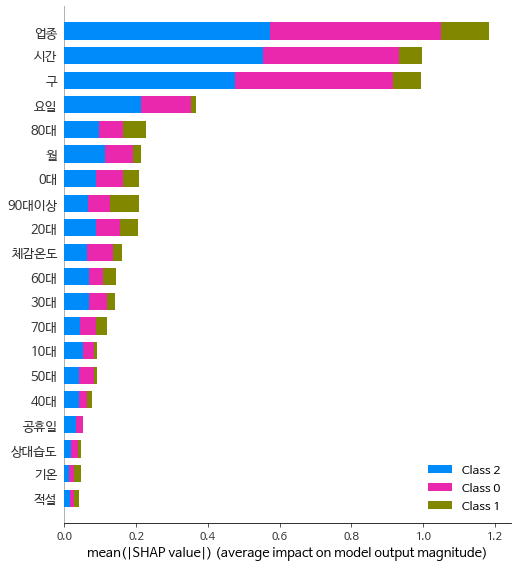

In [187]:
explainer = shap.TreeExplainer(lgbm2)
shap_values = explainer.shap_values(X_val_encoded.iloc[:500])

shap.initjs()
shap.summary_plot(shap_values, X_val_encoded.iloc[:500], plot_type = 'bar')

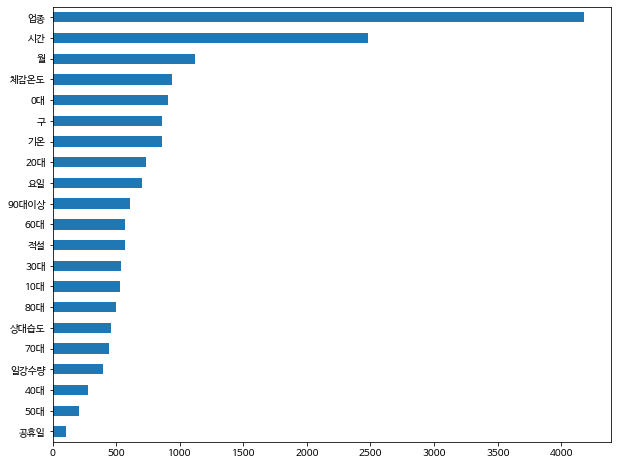

In [188]:
fig = plt.figure(figsize = (10,8))
pd.Series(lgbm2.feature_importances_, index = X_val.columns).sort_values().plot.barh()

### 여러가지 조합 결과 날씨관련변수를 모두 제거하고, 나이대도 0대와 90대이상을 제거하는게 XGBoost에서는 성능이 가장 높았다.

In [9]:
df_final2 = df_final.drop(columns = ['적설','일강수량', '상대습도', '체감온도', '90대이상', '0대', '50대', '주말', '미세',
                                    '초미세', '축구', '풍속'])
print(df_final2.shape)
df_final2.drop_duplicates(inplace = True) # 중복 때문에 기온을 넣었음.
print(df_final2.shape)
display(df_final2.head())

X_train, X_test = train_test_split(df_final2, test_size = 0.2, random_state = 42)
X_train, X_val = train_test_split(X_train, test_size = 0.2, random_state = 42)
y_train, y_val, y_test = X_train.pop('주문정도'), X_val.pop('주문정도'), X_test.pop('주문정도')

#Target이 아닌 One Hot Encoder 사용
encoder = OneHotEncoder(use_cat_names = True)

X_train_encoded = encoder.fit_transform(X_train, y_train)
X_val_encoded = encoder.transform(X_val)

(721437, 15)
(716742, 15)


,시간,업종,구,월,기온,공휴일,요일,10대,20대,30대,40대,60대,70대,80대,주문정도
0,14,치킨,중구,5,21.0,0.0,일,7507,22325,21749,18632,16464,9514,3846,1
1,23,치킨,중구,5,15.3,0.0,월,7507,22325,21749,18632,16464,9514,3846,1
2,12,치킨,중구,5,23.9,0.0,목,7507,22325,21749,18632,16464,9514,3846,1
3,22,치킨,중구,6,17.5,0.0,토,7507,22325,21749,18632,16464,9514,3846,1
4,19,치킨,중구,6,24.9,0.0,수,7507,22325,21749,18632,16464,9514,3846,1


In [382]:
xgb3 =  XGBClassifier(n_estimators = 120, random_state = 42, n_jobs = -1, tree_method = 'gpu_hist', predictor = 'gpu_predictor',
                     max_depth = 6, learning_rate = 0.4)
eval_set = [(X_train_encoded, y_train),
           (X_val_encoded, y_val)]
xgb3.fit(X_train_encoded, y_train, eval_set = eval_set, eval_metric = 'auc', early_stopping_rounds = 5)

[0]	validation_0-auc:0.72166	validation_1-auc:0.72201
[1]	validation_0-auc:0.74224	validation_1-auc:0.74341
[2]	validation_0-auc:0.75840	validation_1-auc:0.75884
[3]	validation_0-auc:0.76781	validation_1-auc:0.76764
[4]	validation_0-auc:0.77859	validation_1-auc:0.77826
[5]	validation_0-auc:0.78660	validation_1-auc:0.78613
[6]	validation_0-auc:0.79361	validation_1-auc:0.79291
[7]	validation_0-auc:0.79682	validation_1-auc:0.79606
[8]	validation_0-auc:0.80727	validation_1-auc:0.80664
[9]	validation_0-auc:0.80950	validation_1-auc:0.80865
[10]	validation_0-auc:0.81511	validation_1-auc:0.81448
[11]	validation_0-auc:0.81815	validation_1-auc:0.81729
[12]	validation_0-auc:0.82008	validation_1-auc:0.81910
[13]	validation_0-auc:0.82346	validation_1-auc:0.82241
[14]	validation_0-auc:0.82575	validation_1-auc:0.82451
[15]	validation_0-auc:0.82661	validation_1-auc:0.82529
[16]	validation_0-auc:0.83035	validation_1-auc:0.82904
[17]	validation_0-auc:0.83271	validation_1-auc:0.83134
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.4, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=120, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob',
              predictor='gpu_predictor', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [383]:
accuracy_and_auc2(xgb3) #날씨 뺴니까 성능 향상
#OHE 쓸 때 성능이 젤 좋음.

학습 정확도 0.7307472630004752
검증 정확도 0.726427680743641
학습 AUC 0.8807682738888801
검증 AUC 0.8708068662100683
학습과 검증 AUC 차이 0.009961407678811818


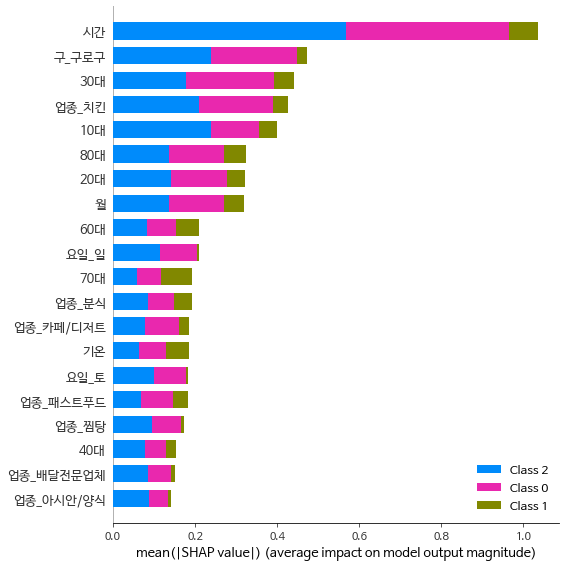

In [384]:
explainer = shap.TreeExplainer(xgb3)
shap_values = explainer.shap_values(X_val_encoded.iloc[:500])

shap.initjs()
shap.summary_plot(shap_values, X_val_encoded.iloc[:500], plot_type = 'bar')

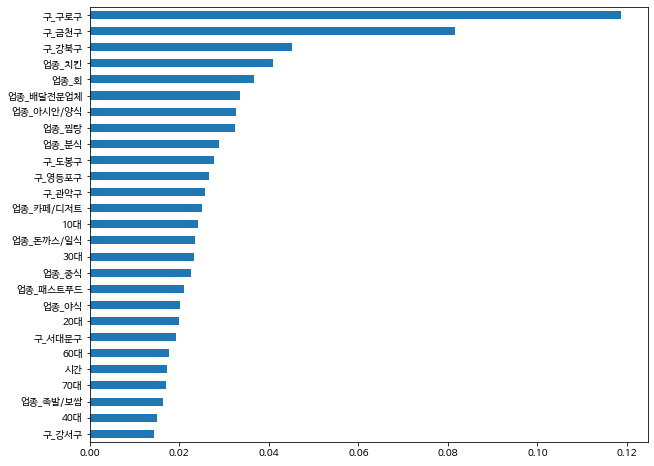

In [385]:
fig = plt.figure(figsize = (10,8))
pd.Series(xgb3.feature_importances_, index = X_val_encoded.columns).sort_values().iloc[30:].plot.barh()

In [386]:
X_test_encoded = encoder.transform(X_test)
y_prob = xgb3.predict_proba(X_test_encoded)
test_roc = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")
print('테스트 정확도', xgb3.score(X_test_encoded, y_test))
print('테스트 AUC', roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted"))

테스트 정확도 0.7245812666987562
테스트 AUC 0.8703433178202166


### LGBM 변수조합 찾기
### 여러가지 실험 결과 최종모델 LGBM.
['업종', '시간', '월', '요일', '구', '50대를 제외한 나이대 모두, '공휴일'] 을 변수로 사용하는게 가장 좋았다.

열심히 추가했던 날씨, 미세먼지, 축구 변수는 아쉽지만 성능을 올리는데 크게 영향을 못 미쳤다.

In [11]:
#날씨관련해서 모두 제거하고 돌려보자.
#df_final2 = df_final.drop(columns = ['축구', '풍속','상대습도', '초미세', '미세', '일강수량', '적설', '체감온도'])
df_final2 = df_final.drop(columns = ['풍속','상대습도', '초미세', '미세', '일강수량', '적설', '체감온도'])
print(df_final2.shape)
df_final2.drop_duplicates(inplace = True)
print(df_final2.shape)
display(df_final2.head())
X_train, X_test = train_test_split(df_final2, test_size = 0.2, random_state = 42)
X_train, X_val = train_test_split(X_train, test_size = 0.2, random_state = 42)
y_train, y_val, y_test = X_train.pop('주문정도'), X_val.pop('주문정도'), X_test.pop('주문정도')

#encoder = TargetEncoder(min_samples_leaf = 2, smoothing = 1000)
#encoder = OrdinalEncoder()
encoder = OneHotEncoder(use_cat_names = True)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_val_encoded = encoder.transform(X_val)

(721437, 20)
(716742, 20)


,시간,업종,구,월,기온,공휴일,요일,주말,축구,0대,10대,20대,30대,40대,50대,60대,70대,80대,90대이상,주문정도
0,14,치킨,중구,5,21.0,0.0,일,1.0,0.0,7534,7507,22325,21749,18632,20811,16464,9514,3846,541,1
1,23,치킨,중구,5,15.3,0.0,월,0.0,0.0,7534,7507,22325,21749,18632,20811,16464,9514,3846,541,1
2,12,치킨,중구,5,23.9,0.0,목,0.0,0.0,7534,7507,22325,21749,18632,20811,16464,9514,3846,541,1
3,22,치킨,중구,6,17.5,0.0,토,1.0,0.0,7534,7507,22325,21749,18632,20811,16464,9514,3846,541,1
4,19,치킨,중구,6,24.9,0.0,수,0.0,0.0,7534,7507,22325,21749,18632,20811,16464,9514,3846,541,1


In [ ]:
lgbm3 =  LGBMClassifier(n_estimators = 330, random_state = 42, n_jobs = -1,max_depth = 5,learning_rate = 0.22)
eval_set = [(X_train_encoded, y_train),
           (X_val_encoded, y_val)]
lgbm3.fit(X_train_encoded, y_train, eval_set = eval_set, eval_metric = 'multi_logloss', early_stopping_rounds = 5)

In [445]:
#xgboost보다 성능이 좋다. OHE가 성능이 더 좋다.
accuracy_and_auc2(lgbm3)

학습 정확도 0.732990490806908
검증 정확도 0.7271776000837119
학습 AUC 0.8826146427814654
검증 AUC 0.872723329974138
학습과 검증 AUC 차이 0.009891312807327357


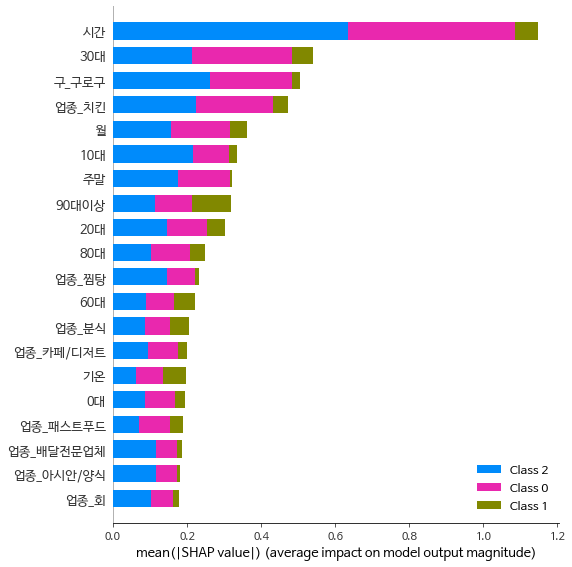

In [446]:
explainer = shap.TreeExplainer(lgbm3)
shap_values = explainer.shap_values(X_val_encoded.iloc[:500])

shap.initjs()
shap.summary_plot(shap_values, X_val_encoded.iloc[:500], plot_type = 'bar')

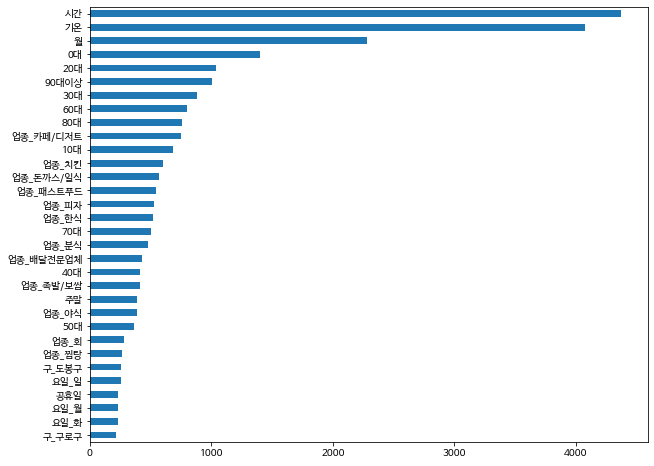

In [447]:
fig = plt.figure(figsize = (10,8))
pd.Series(lgbm3.feature_importances_, index = X_val_encoded.columns).sort_values().iloc[30:].plot.barh()

In [448]:
X_test_encoded = encoder.transform(X_test)
y_prob = lgbm3.predict_proba(X_test_encoded)
test_roc = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")

print('테스트 정확도', lgbm3.score(X_test_encoded,y_test))
print('테스트 AUC', roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted"))

테스트 정확도 0.7262066704336968
테스트 AUC 0.8723435259019805


최종적으로 테스트 score가 0.872다. OHE를 써서 원래 중요했던 '구'변수의 의미가 분산되었기 때문에 중요하지 않은 변수로 취급되었다. 하지만 OHE를 썼을 때 성능이 가장 좋았다.

### 가상의 상황 테스트

In [449]:
df_final2.head()

,시간,업종,구,월,기온,공휴일,요일,주말,축구,0대,10대,20대,30대,40대,50대,60대,70대,80대,90대이상,주문정도
0,14,치킨,중구,5,21.0,0.0,일,1.0,0.0,7534,7507,22325,21749,18632,20811,16464,9514,3846,541,1
1,23,치킨,중구,5,15.3,0.0,월,0.0,0.0,7534,7507,22325,21749,18632,20811,16464,9514,3846,541,1
2,12,치킨,중구,5,23.9,0.0,목,0.0,0.0,7534,7507,22325,21749,18632,20811,16464,9514,3846,541,1
3,22,치킨,중구,6,17.5,0.0,토,1.0,0.0,7534,7507,22325,21749,18632,20811,16464,9514,3846,541,1
4,19,치킨,중구,6,24.9,0.0,수,0.0,0.0,7534,7507,22325,21749,18632,20811,16464,9514,3846,541,1


In [586]:
df_test = pd.DataFrame([df_final2.loc[df_final2['구'] == '구로구'].iloc[0]])
test_list = [20,'치킨', '구로구', 3,20 ,0, '금', 0, 1]
for i in range(len(test_list)):
    df_test.iloc[:,i] = test_list[i]
df_test.drop(columns = ['주문정도'], inplace = True)
df_test.head() # 인구수는 그대로 하고 나머지 변수만 바꿔서 주문 정도를 예측해보자.

,시간,업종,구,월,기온,공휴일,요일,주말,축구,0대,10대,20대,30대,40대,50대,60대,70대,80대,90대이상
55333,20,치킨,구로구,3,20.0,0.0,금,0.0,1.0,31456,31404,55916,70334,68362,72672,59195,30190,10270,1202


In [587]:
df_final2.duplicated().sum()

0

In [589]:
test_encoded = encoder.transform(df_test)
result = lgbm3.predict(test_encoded)
print(result[0])
if result[0] == 1:
    print('주문량이 적을 것입니다.')
elif result[0] == 2:
    print('주문량이 보통일 것입니다.')
else:
    print('주문량이 많을 것입니다.')


3
주문량이 많을 것입니다.


In [591]:
df_test = pd.DataFrame([df_final2.loc[df_final2['구'] == '성북구'].iloc[0]])
test_list = [20,'치킨', '성북구', 9,24 ,0, '금', 0, 1]
for i in range(len(test_list)):
    df_test.iloc[:,i] = test_list[i]
df_test.drop(columns = ['주문정도'], inplace = True)
df_test.head() # 인구수는 그대로 하고 나머지 변수만 바꿔서 주문 정도를 예측해보자.

,시간,업종,구,월,기온,공휴일,요일,주말,축구,0대,10대,20대,30대,40대,50대,60대,70대,80대,90대이상
26850,20,치킨,성북구,9,24.0,0.0,금,0.0,1.0,30256,37906,79844,61589,69876,66865,50190,31759,12237,1531


In [592]:
test_encoded = encoder.transform(df_test)
result = lgbm3.predict(test_encoded)
print(result[0])
if result[0] == 1:
    print('주문량이 적을 것입니다.')
elif result[0] == 2:
    print('주문량이 보통일 것입니다.')
else:
    print('주문량이 많을 것입니다.')


2
주문량이 보통일 것입니다.


In [594]:
df_test = pd.DataFrame([df_final2.loc[df_final2['구'] == '성북구'].iloc[0]])
test_list = [20,'치킨', '성북구', 3,15 ,0, '목', 0, 0]
for i in range(len(test_list)):
    df_test.iloc[:,i] = test_list[i]
df_test.drop(columns = ['주문정도'], inplace = True)
df_test.head() # 인구수는 그대로 하고 나머지 변수만 바꿔서 주문 정도를 예측해보자.

,시간,업종,구,월,기온,공휴일,요일,주말,축구,0대,10대,20대,30대,40대,50대,60대,70대,80대,90대이상
26850,20,치킨,성북구,3,15.0,0.0,목,0.0,0.0,30256,37906,79844,61589,69876,66865,50190,31759,12237,1531


In [595]:
test_encoded = encoder.transform(df_test)
result = lgbm3.predict(test_encoded)
print(result[0])
if result[0] == 1:
    print('주문량이 적을 것입니다.')
elif result[0] == 2:
    print('주문량이 보통일 것입니다.')
else:
    print('주문량이 많을 것입니다.')


1
주문량이 적을 것입니다.


### 최종 지도 시각화
인구수와 주문건수를 비교하기 위한 시각화

인구가 많으면 주문건수도 많을까??

In [24]:
import json
import folium
map_data = json.load(open(f'{DATA_PATH}Seoul_Gu.json', encoding = 'cp949'))

In [46]:
population = pd.read_csv(f'{DATA_PATH}population.csv')
population.head()

,기간,행정구역별,성별,계,0~4세,5~9세,10~14세,15~19세,20~24세,25~29세,...,50~54세,55~59세,60~64세,65~69세,70~74세,75~79세,80~84세,85~89세,90~94세,95세 이상+
0,2019,합계,계,"9,662,041","309,701","348,151","355,751","442,841","682,985","825,843",...,"767,181","774,158","692,351","476,772","370,383","283,560","166,370","72,512","25,568","6,587"
1,2019,합계,남자,"4,698,629","158,665","178,816","183,403","226,589","321,742","403,906",...,"374,998","372,714","328,454","224,384","170,499","127,618","66,389","23,101","6,312","1,515"
2,2019,합계,여자,"4,963,412","151,036","169,335","172,348","216,252","361,243","421,937",...,"392,183","401,444","363,897","252,388","199,884","155,942","99,981","49,411","19,256","5,072"
3,2019,종로구,계,"154,458","3,588","4,402","4,850","7,766","14,775","14,764",...,"12,324","12,519","10,808","7,301","6,107","5,418","3,353","1,544",553,158
4,2019,종로구,남자,"74,886","1,793","2,244","2,501","4,207","6,561","7,436",...,"5,944","6,159","5,370","3,482","2,703","2,371","1,343",536,165,42


In [47]:
def to_int(s):
    return int(s.replace(',',''))

In [48]:
# , 제거
col = population.columns[3:].tolist()
for i in col:
    population[i] = population[i].apply(to_int)

In [49]:
#10대, 20대처럼 10살 단위로 묶기
col = population.columns[4:].tolist()
age = 0
for i in range(0,len(col),2):
    globals()['population_{}'.format(age*10)] = population.iloc[:,i+4] + population.iloc[:,i+5] # 글로벌 변수로 한 번에 할당.
    age = age + 1

In [50]:
population['0대'] = population_0
population['10대'] = population_10
population['20대'] = population_20
population['30대'] = population_30
population['40대'] = population_40
population['50대'] = population_50
population['60대'] = population_60
population['70대'] = population_70
population['80대'] = population_80
population['90대이상'] = population_90

In [51]:
#성별이랑 불필요한 나이대 제거
population = population.loc[(population['성별'] == '계') & (population['행정구역별'] != '합계')]
population.drop(columns = population.columns[2:24].tolist(),inplace =True)
population.head()

,기간,행정구역별,0대,10대,20대,30대,40대,50대,60대,70대,80대,90대이상
3,2019,종로구,7990,12616,29539,21596,22632,24843,18109,11525,4897,711
6,2019,중구,7534,7507,22325,21749,18632,20811,16464,9514,3846,541
9,2019,용산구,14502,15798,34101,39772,36193,35090,25596,15570,6844,953
12,2019,성동구,21784,21022,51136,52128,46729,48152,34574,19625,7368,922
15,2019,광진구,22040,26935,69289,60924,54683,57404,40517,21242,7663,1014


In [52]:
population = population.loc[population['기간'] == 2021]
population['총인구수'] = population.iloc[:,2:].sum(axis = 1)
population.head()

,기간,행정구역별,0대,10대,20대,30대,40대,50대,60대,70대,80대,90대이상,총인구수
159,2021,종로구,7119,10303,28111,20817,21152,24454,19852,11403,5524,818,149553
162,2021,중구,6598,6393,21004,20848,17852,20057,17839,9815,4347,645,125398
165,2021,용산구,12828,14513,33182,38027,34788,35269,27975,15569,7572,1108,220831
168,2021,성동구,20677,19876,53606,54589,47399,49839,39471,20730,8681,1075,315943
171,2021,광진구,19545,24682,66512,58645,52094,55594,45107,22208,8909,1151,354447


In [69]:
population

,기간,행정구역별,0대,10대,20대,30대,40대,50대,60대,70대,80대,90대이상,총인구수
159,2021,종로구,7119,10303,28111,20817,21152,24454,19852,11403,5524,818,149553
162,2021,중구,6598,6393,21004,20848,17852,20057,17839,9815,4347,645,125398
165,2021,용산구,12828,14513,33182,38027,34788,35269,27975,15569,7572,1108,220831
168,2021,성동구,20677,19876,53606,54589,47399,49839,39471,20730,8681,1075,315943
171,2021,광진구,19545,24682,66512,58645,52094,55594,45107,22208,8909,1151,354447
174,2021,동대문구,20194,22708,66375,53093,50272,53234,47608,27366,11261,1287,353398
177,2021,중랑구,21684,25214,53764,56036,55583,67066,59055,30630,11456,1362,381850
180,2021,성북구,26635,34883,77236,58684,66125,66851,54609,32064,14089,1767,432943
183,2021,강북구,14793,20689,42514,37596,44039,50626,46252,28995,11484,1311,298299
186,2021,도봉구,17784,24209,42888,39706,46638,55484,50507,27554,12097,1637,318504


In [58]:
map_data

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[127.012, 37.582],
      [127.015, 37.582],
      [127.016, 37.582],
      [127.017, 37.582],
      [127.017, 37.581],
      [127.017, 37.58],
      [127.018, 37.58],
      [127.018, 37.579],
      [127.018, 37.578],
      [127.019, 37.578],
      [127.02, 37.578],
      [127.019, 37.578],
      [127.02, 37.578],
      [127.02, 37.579],
      [127.021, 37.579],
      [127.022, 37.579],
      [127.023, 37.578],
      [127.023, 37.577],
      [127.023, 37.576],
      [127.023, 37.575],
      [127.023, 37.572],
      [127.018, 37.57],
      [127.015, 37.57],
      [127.001, 37.569],
      [126.997, 37.569],
      [126.99, 37.568],
      [126.976, 37.569],
      [126.969, 37.568],
      [126.967, 37.566],
      [126.954, 37.579],
      [126.957, 37.58],
      [126.958, 37.584],
      [126.958, 37.594],
      [126.958, 37.598],
      [126.953, 37.6],
      [126.954, 37.605

In [77]:
# 구별 인구수 지도
# 색이 붉은색으로 진할수록 인구가 많은 것. 
map = folium.Map(location=[37.5502, 126.982], zoom_start=11)
map.choropleth(geo_data=map_data,
              data = population,
              columns = ['행정구역별', '총인구수'],
              fill_color='YlOrRd',
              key_on='feature.properties.SIG_KOR_NM')
map

In [92]:
df_map_gu = df_final.groupby('구')['주문정도'].sum().to_frame().reset_index()
df_map_gu.head()

,구,주문정도
0,강남구,6817
1,강동구,43
2,강북구,12269
3,강서구,18716
4,관악구,110934


In [93]:
# 구별 주문정도 지도
map2 = folium.Map(location=[37.5502, 126.982], zoom_start=11)
map2.choropleth(geo_data=map_data,
              data = df_map_gu,
              columns = ['구', '주문정도'],
              fill_color='YlOrRd',
              key_on='feature.properties.SIG_KOR_NM')
map2

# 치킨과 축구
축구 경기가 있는 날이면 평소보다 치킨을 많이 시킬까?

In [96]:
df_soccer = df_final.loc[(df_final['축구'] == 1) & (df_final['업종'] == '치킨')]
df_no = df_final.loc[(df_final['축구'] == 0) & (df_final['업종'] == '치킨')]

print(df_soccer['주문정도'].value_counts(normalize = True))
print(df_no['주문정도'].value_counts(normalize = True))

3    0.615385
1    0.222222
2    0.162393
Name: 주문정도, dtype: float64
3    0.500574
1    0.329206
2    0.170219
Name: 주문정도, dtype: float64


3    0.615385
1    0.222222
2    0.162393
Name: 주문정도, dtype: float64


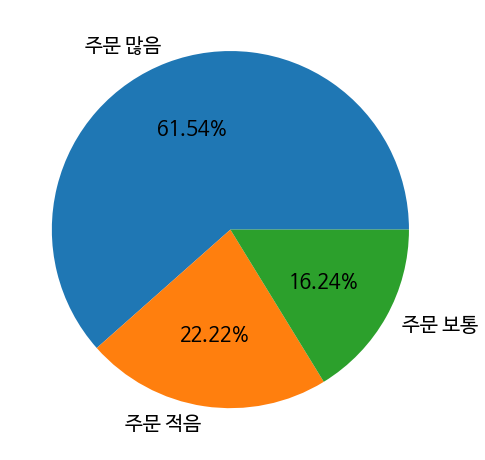

In [102]:
# 축구경기가 있는 날
df_pie1 = df_soccer['주문정도'].value_counts(normalize = True)
print(df_pie1)
fig = plt.figure(figsize = (8,15))
plt.pie(df_pie1, labels = ['주문 많음', '주문 적음', '주문 보통'], autopct = '%.2f%%',textprops={'fontsize': 20})
plt.show()

3    0.500574
1    0.329206
2    0.170219
Name: 주문정도, dtype: float64


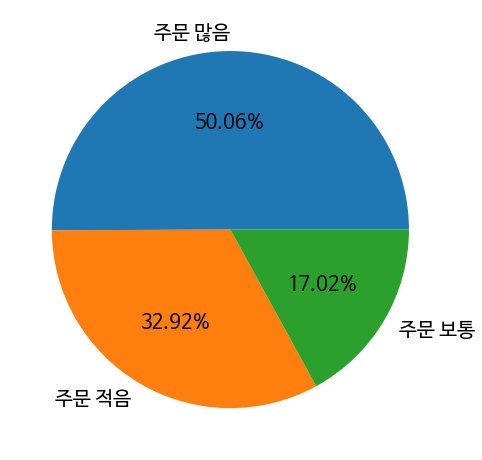

In [103]:
# 축구 경기가 없는 날
df_pie2 = df_no['주문정도'].value_counts(normalize = True)
print(df_pie2)
fig = plt.figure(figsize = (8,15))
plt.pie(df_pie2, labels = ['주문 많음', '주문 적음', '주문 보통'], autopct = '%.2f%%',textprops={'fontsize': 20})
plt.show()